In [1]:
import numpy as np
import random
import sys
import csv
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import time
import math
import bottleneck as bn
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/Colab Notebooks/Query Operators'

/content/drive/My Drive/Colab Notebooks/Query Operators


In [4]:
num_iter = 20
hidden_size = 32
num_layers = 1



# only one can be set 1
use_embedding = 1
use_linear_reduction = 0
###
atten_decoder = 1
use_dropout = 0
use_average_embedding = 1

weight = 10
labmda = 0
topk_labels = 3

# It should be the same as the reductioned input in decoder's cat function

teacher_forcing_ratio = 0
MAX_LENGTH = 1000
learning_rate = 0.001
optimizer_option = 2
print_val = 3000
use_cuda = torch.cuda.is_available()
# use_cuda = False

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
print(f"Using cuda: {use_cuda}")

Tesla K80
1
Using cuda: True


In [5]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size - n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]


def get_precision_recall_Fscore(groundtruth, pred):
    a = groundtruth
    b = pred
    correct = 0
    truth = 0
    positive = 0

    for idx in range(len(a)):
        if a[idx] == 1:
            truth += 1
            if b[idx] == 1:
                correct += 1
        if b[idx] == 1:
            positive += 1

    flag = 0
    if 0 == positive:
        precision = 0
        flag = 1
        # print('postivie is 0')
    else:
        precision = correct / positive
    if 0 == truth:
        recall = 0
        flag = 1
        # print('recall is 0')
    else:
        recall = correct / truth

    if flag == 0 and precision + recall > 0:
        F = 2 * precision * recall / (precision + recall)
    else:
        F = 0
    return precision, recall, F, correct


def get_F_score(prediction, test_Y):
    jaccard_similarity = []
    prec = []
    rec = []

    count = 0
    for idx in range(len(test_Y)):
        pred = prediction[idx]
        T = 0
        P = 0
        correct = 0
        for id in range(len(pred)):
            if test_Y[idx][id] == 1:
                T = T + 1
                if pred[id] == 1:
                    correct = correct + 1
            if pred[id] == 1:
                P = P + 1

        if P == 0 or T == 0:
            continue
        precision = correct / P
        recall = correct / T
        prec.append(precision)
        rec.append(recall)
        if correct == 0:
            jaccard_similarity.append(0)
        else:
            jaccard_similarity.append(2 * precision * recall / (precision + recall))
        count = count + 1

    print(
        'average precision: ' + str(np.mean(prec)))
    print('average recall : ' + str(
        np.mean(rec)))
    print('average F score: ' + str(
        np.mean(jaccard_similarity)))


def get_DCG(groundtruth, pred_rank_list, k):
    count = 0
    dcg = 0
    for pred in pred_rank_list:
        if count >= k:
            break
        if groundtruth[pred] == 1:
            dcg += (1) / math.log2(count + 1 + 1)
        count += 1

    return dcg


def get_NDCG(groundtruth, pred_rank_list, k):
    count = 0
    dcg = 0
    for pred in pred_rank_list:
        if count >= k:
            break
        if groundtruth[pred] == 1:
            dcg += (1) / math.log2(count + 1 + 1)
        count += 1
    idcg = 0
    num_real_item = np.sum(groundtruth)
    num_item = int(min(num_real_item, k))
    for i in range(num_item):
        idcg += (1) / math.log2(i + 1 + 1)
    ndcg = dcg / idcg
    return ndcg


def get_HT(groundtruth, pred_rank_list, k):
    count = 0
    for pred in pred_rank_list:
        if count >= k:
            break
        if groundtruth[pred] == 1:
            return 1
        count += 1

    return 0

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.reduction = nn.Linear(input_size, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.time_embedding = nn.Embedding(input_size, hidden_size)
        self.time_weight = nn.Linear(input_size, input_size)
        if use_embedding or use_linear_reduction:
            self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        else:
            self.gru = nn.GRU(input_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        if use_embedding:
            list = Variable(torch.LongTensor(input).view(-1, 1))
            if use_cuda:
                list = list.cuda()
            average_embedding = Variable(torch.zeros(hidden_size)).view(1, 1, -1)
            # sum_embedding = Variable(torch.zeros(hidden_size)).view(1,1,-1)
            vectorized_input = Variable(torch.zeros(self.input_size)).view(-1)
            if use_cuda:
                average_embedding = average_embedding.cuda()
                # sum_embedding = sum_embedding.cuda()
                vectorized_input = vectorized_input.cuda()

            for ele in list:
                embedded = self.embedding(ele).view(1, 1, -1)
                tmp = average_embedding.clone()
                average_embedding = tmp + embedded
                # embedded = self.time_embedding(ele).view(1, 1, -1)
                # tmp = sum_embedding.clone()
                # sum_embedding = tmp + embedded
                vectorized_input[ele] = 1

            # normalize_length = Variable(torch.LongTensor(len(idx_list)))
            # if use_cuda:
            #     normalize_length = normalize_length.cuda()
            if use_average_embedding:
                tmp = [1] * hidden_size
                length = Variable(torch.FloatTensor(tmp))
                if use_cuda:
                    length = length.cuda()
                # for idx in range(hidden_size):
                real_ave = average_embedding.view(-1) / length
                average_embedding = real_ave.view(1, 1, -1)

            embedding = average_embedding
        else:
            tensorized_input = torch.from_numpy(input).clone().type(torch.FloatTensor)
            inputs = Variable(torch.unsqueeze(tensorized_input, 0).view(1, -1))
            if use_cuda:
                inputs = inputs.cuda()
            if use_linear_reduction == 1:
                reduced_input = self.reduction(inputs)
            else:
                reduced_input = inputs

            embedding = torch.unsqueeze(reduced_input, 0)

        output, hidden = self.gru(embedding, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(num_layers, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout_p=0.2, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        if use_embedding or use_linear_reduction:
            self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
            self.attn1 = nn.Linear(self.hidden_size + output_size, self.hidden_size)
        else:
            self.attn = nn.Linear(self.hidden_size + self.output_size, self.output_size)

        if use_embedding or use_linear_reduction:
            self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.attn_combine3 = nn.Linear(self.hidden_size * 2 + output_size, self.hidden_size)
        else:
            self.attn_combine = nn.Linear(self.hidden_size + self.output_size, self.hidden_size)
        self.attn_combine5 = nn.Linear(self.output_size, self.output_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.reduction = nn.Linear(self.output_size, self.hidden_size)
        if use_embedding or use_linear_reduction:
            self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        else:
            self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, history_record, last_hidden):
        if use_embedding:
            list = Variable(torch.LongTensor(input).view(-1, 1))
            if use_cuda:
                list = list.cuda()
            average_embedding = Variable(torch.zeros(hidden_size)).view(1, 1, -1)
            if use_cuda:
                average_embedding = average_embedding.cuda()

            for ele in list:
                embedded = self.embedding(ele).view(1, 1, -1)
                tmp = average_embedding.clone()
                average_embedding = tmp + embedded

            if use_average_embedding:
                tmp = [1] * hidden_size
                length = Variable(torch.FloatTensor(tmp))
                if use_cuda:
                    length = length.cuda()
                # for idx in range(hidden_size):
                real_ave = average_embedding.view(-1) / length
                average_embedding = real_ave.view(1, 1, -1)

            embedding = average_embedding
        else:
            tensorized_input = torch.from_numpy(input).clone().type(torch.FloatTensor)
            inputs = Variable(torch.unsqueeze(tensorized_input, 0).view(1, -1))
            if use_cuda:
                inputs = inputs.cuda()
            if use_linear_reduction == 1:
                reduced_input = self.reduction(inputs)
            else:
                reduced_input = inputs

            embedding = torch.unsqueeze(reduced_input, 0)

        if use_dropout:
            droped_ave_embedded = self.dropout(embedding)
        else:
            droped_ave_embedded = embedding

        history_context = Variable(torch.FloatTensor(history_record).view(1, -1))
        if use_cuda:
            history_context = history_context.cuda()

        attn_weights = F.softmax(
            self.attn(torch.cat((droped_ave_embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        element_attn_weights = F.softmax(
            self.attn1(torch.cat((history_context, hidden[0]), 1)), dim=1)

        # attn_applied = torch.bmm(element_attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        # attn_embedd = element_attn_weights * droped_ave_embedded[0]

        output = torch.cat((droped_ave_embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        # output = torch.cat((droped_ave_embedded[0], attn_applied[0], time_coef.unsqueeze(0)), 1)
        # output = self.attn_combine3(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        linear_output = self.out(output[0])
        # output_user_item = F.softmax(linear_output)

        value = torch.sigmoid(self.attn_combine5(history_context).unsqueeze(0))

        one_vec = Variable(torch.ones(self.output_size).view(1, -1))
        if use_cuda:
            one_vec = one_vec.cuda()

        # ones_set = torch.index_select(value[0,0], 1, ones_idx_set[:, 1])
        res = history_context.clone()
        res[history_context != 0] = 1

        # output = F.softmax(linear_output * (one_vec - res * value[0]) + history_context * value[0], dim=1)
        output = F.softmax(linear_output, dim=1)

        return output.view(1, -1), hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(num_layers, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [8]:
class custom_MultiLabelLoss_torch(nn.modules.loss._Loss):
    def __init__(self):
        super(custom_MultiLabelLoss_torch, self).__init__()

    def forward(self, pred, target, weights):
        mseloss = torch.sum(weights * torch.pow((pred - target), 2))
        pred = pred.data
        target = target.data
        
        ones_idx_set = (target == 1).nonzero()
        zeros_idx_set = (target == 0).nonzero()
        
        ones_set = torch.index_select(pred, 1, ones_idx_set[:, 1])
        zeros_set = torch.index_select(pred, 1, zeros_idx_set[:, 1])
        
        repeat_ones = ones_set.repeat(1, zeros_set.shape[1])
        repeat_zeros_set = torch.transpose(zeros_set.repeat(ones_set.shape[1], 1), 0, 1).clone()
        repeat_zeros = repeat_zeros_set.reshape(1, -1)
        difference_val = -(repeat_ones - repeat_zeros)
        exp_val = torch.exp(difference_val)
        exp_loss = torch.sum(exp_val)
        normalized_loss = exp_loss / (zeros_set.shape[1] * ones_set.shape[1])
        set_loss = Variable(torch.FloatTensor([labmda * normalized_loss]), requires_grad=True)
        if use_cuda:
            set_loss = set_loss.cuda()
        loss = mseloss + set_loss
        # loss = mseloss
        return loss

In [9]:
def train(input_variable, target_variable, encoder, decoder, codes_inverse_freq, encoder_optimizer, decoder_optimizer,
          criterion, output_size, next_k_step, update_params, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = len(input_variable)
    target_length = len(target_variable)

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    if use_cuda:
        encoder_outputs = encoder_outputs.cuda()

    loss = 0

    history_record = np.zeros(output_size)
    for ei in range(input_length - 1):
        if ei == 0:
            continue
        for ele in input_variable[ei]:
            history_record[ele] += 1 / (input_length - 2)

    for ei in range(input_length - 1):
        if ei == 0:
            continue
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei - 1] = encoder_output[0][0]

    last_input = input_variable[input_length - 2]
    decoder_hidden = encoder_hidden
    last_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    topk = 1

    decoder_input = last_input
    for di in range(next_k_step):

        if atten_decoder:
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, history_record, last_hidden)
        else:
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(topk)
        ni = topi[0][0]

        # activation_bound
        # topk_labels
        # target_neg = zero2neg(target_variable[di])

        vectorized_target = np.zeros(output_size)
        for idx in target_variable[di + 1]:
            vectorized_target[idx] = 1

        target = Variable(torch.FloatTensor(vectorized_target).view(1, -1))
        if use_cuda:
            target = target.cuda()
        weights = Variable(torch.FloatTensor(codes_inverse_freq).view(1, -1))
        if use_cuda:
            weights = weights.cuda()
        tt = criterion(decoder_output, target, weights)
        # tt = criterion(decoder_output, target)
        # tt = torch.sum(weights*torch.pow((decoder_output - target),2))
        loss += tt
        decoder_input = target_variable[di + 1]
        # loss += multilable_loss(decoder_output, target)

    # encoder_optimizer.zero_grad()
    # decoder_optimizer.zero_grad()
    if update_params:
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

    return loss.item() / target_length

In [10]:
def custom_after_subplot(ax: plt.Axes, group: str, x_label: str):
    if group == 'folds':
        ax.set_xlabel("fold")
    if group == 'epochs':
        ax.set_xlabel("epochs")
   

def trainIters(folds, output_size, encoder, decoder, model_id, weights,
                       next_k_step, n_iters, print_every=300):
    start = time.time()
    full_training_losses = []
    full_validation_losses = []

    epoch_metrics = {}
    fold_metrics = {}


    if optimizer_option == 1:
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    elif optimizer_option == 2:
        # encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-09, weight_decay=0)
        # encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate, betas=(0.88, 0.95), eps=1e-08, weight_decay=0)
        encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-11,
                                             weight_decay=0)
        decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-11,
                                             weight_decay=0)
    elif optimizer_option == 3:
        encoder_optimizer = torch.optim.RMSprop(encoder.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08,
                                                weight_decay=0, momentum=0, centered=False)
        decoder_optimizer = torch.optim.RMSprop(decoder.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08,
                                                weight_decay=0, momentum=0, centered=False)
    elif optimizer_option == 4:
        encoder_optimizer = torch.optim.Adadelta(encoder.parameters(), lr=learning_rate, rho=0.9, eps=1e-06,
                                                 weight_decay=0)
        decoder_optimizer = torch.optim.Adadelta(decoder.parameters(), lr=learning_rate, rho=0.9, eps=1e-06,
                                                 weight_decay=0)
    
    total_iter = 0

    criterion = custom_MultiLabelLoss_torch()
    # criterion = nn.MSELoss()
    # criterion = nn.NLLLoss()
    # criterion = nn.MultiLabelSoftMarginLoss(size_average=False)
    # criterion = nn.BCELoss()

    for j in range(n_iters):
        logs = {}
        training_loss_total = 0.0
        validation_loss_total = 0.0
        validation_recall_total = 0.0
        validation_precision_total = 0.0
        validation_f1_total = 0.0
        validation_ndcg_total = 0.0
        validation_hr_total = 0.0

        for fold_index, fold in enumerate(folds):           
            print("Epoch:", j, "Fold:", fold_index)
            training_loss = 0.0
            validation_loss = 0.0
            X_train, y_train = fold[0][0], fold[0][1]
            X_val, y_val = fold[1][0], fold[1][1]

            # Training set
            for iter in range(len(y_train)):
                # print('Train iter ', iter, ' out of ', len(y_train)) if iter % 100 == 0 else 0
                input_variable = X_train[iter] # past sequence
                target_variable = y_train[iter] # future sequence

                loss = train(input_variable, target_variable, encoder,
                            decoder, weights, encoder_optimizer, decoder_optimizer, criterion, output_size,
                            next_k_step, update_params=True)
                training_loss_total += loss
                training_loss += loss
                full_training_losses.append(loss)

                total_iter += 1
            print('Fold avg train loss: ' + str(training_loss / len(y_train)))
            
            # logs['fold_loss'] = training_loss / (len(y_train))

            # Validation set
            with torch.no_grad():
                # Calculate metrics for this fold's validation set
                recall, ndcg, hr, prec, f1 = evaluate(X_val, y_val, encoder, decoder, output_size, next_k_step, 5) 
                print('Fold avg val recall:' + str(recall))
                print('Fold avg val precision:' + str(prec))
                print('Fold avg val f1:' + str(f1))
                print('Fold avg val ndcg:' + str(ndcg))
                print('Fold avg val hr:' + str(hr))
                validation_recall_total += recall
                validation_precision_total += prec
                validation_f1_total += f1
                validation_ndcg_total += ndcg
                validation_hr_total += hr
                
                for iter in range(len(y_val)):
                    # print('Validation iter ', iter, ' out of ', len(y_val)) if iter % 100 == 0 else 0
                    input_variable = X_val[iter] # past sequence
                    target_variable = y_val[iter] # future sequence

                    loss = train(input_variable, target_variable, encoder,
                                decoder, weights, encoder_optimizer, decoder_optimizer, criterion, output_size,
                                next_k_step, update_params=False)
                    validation_loss_total += loss
                    validation_loss += loss
                    full_validation_losses.append(loss)
                print('Fold avg val loss: ' + str(validation_loss / len(y_val)))


        # Metrics per epoch
        training_loss_avg = training_loss_total / (len(folds) * len(y_train))
        validation_loss_avg = validation_loss_total / (len(folds) * len(y_val))
        validation_recall_avg = validation_recall_total / (len(folds))
        validation_precision_avg = validation_precision_total / (len(folds))
        validation_f1_avg = validation_f1_total / (len(folds))
        validation_ndcg_avg = validation_ndcg_total / (len(folds))
        validation_hr_avg = validation_hr_total / (len(folds))

        print('%s (%d %d%%) train %.6f val %.6f' % (timeSince(start, total_iter / (n_iters *  len(folds) * len(y_train))), total_iter, total_iter / (n_iters *  len(folds) * len(y_train)) * 100,training_loss_avg, validation_loss_avg))

        print('Epoch avg val recall:' + str(validation_recall_avg))
        print('Epoch avg val precision:' + str(validation_precision_avg))
        print('Epoch avg val f1:' + str(validation_f1_avg))
        print('Epoch avg val ndcg:' + str(validation_ndcg_avg))
        print('Epoch avg val hr:' + str(validation_hr_avg))
        # lc = pd.DataFrame({"loss": full_training_losses})
        # lc.plot(lw=2, title="training loss");
        # plt.xlabel('iterations');

        filepath = './models/encoder' + (model_id) + '_model_epoch' + str(int(j))
        torch.save(encoder, filepath)
        filepath = './models/decoder' + (model_id) + '_model_epoch' + str(int(j))
        torch.save(decoder, filepath)
        print('Finish epoch: ' + str(j))
        print('Model is saved.')
        sys.stdout.flush()
    # showPlot(plot_losses)
    # print('The loss: ' + str(print_loss_total))




In [11]:
cosine_sim = []
pair_cosine_sim = []


def decoding_next_k_step(encoder, decoder, input_variable, target_variable, output_size, k, num_set_elements):
    encoder_hidden = encoder.initHidden()

    input_length = len(input_variable)
    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
    if use_cuda:
        encoder_outputs = encoder_outputs.cuda()

    loss = 0

    history_record = np.zeros(output_size)
    count = 0
    for ei in range(input_length - 1):
        if ei == 0:
            continue
        for ele in input_variable[ei]:
            history_record[ele] += 1
        count += 1

    history_record = history_record / count

    for ei in range(input_length - 1):
        if ei == 0:
            continue
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei - 1] = encoder_output[0][0]

        for ii in range(k):
            vectorized_target = np.zeros(output_size)
            for idx in target_variable[ii + 1]:
                vectorized_target[idx] = 1

            vectorized_input = np.zeros(output_size)
            for idx in input_variable[ei]:
                vectorized_input[idx] = 1

    decoder_input = input_variable[input_length - 2]

    decoder_hidden = encoder_hidden
    last_hidden = decoder_hidden
    # Without teacher forcing: use its own predictions as the next input
    num_str = 0
    topk = 400
    decoded_vectors = []
    prob_vectors = []
    cout = 0
    for di in range(k):
        if atten_decoder:
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, history_record, last_hidden)
        else:
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(topk)
        ni = topi[0][0]

        vectorized_target = np.zeros(output_size)
        for idx in target_variable[di + 1]:
            vectorized_target[idx] = 1

        # target_topi = vectorized_target.argsort()[::-1][:topk]
        # activation_bound

        count = 0
        start_idx = -1
        end_idx = output_size
        if num_set_elements > 0:
            pick_num = num_set_elements
        else:
            pick_num = np.sum(vectorized_target)
            # print(pick_num)

        tmp = []
        for ele in range(len(topi[0])):
            if count >= pick_num:
                break
            tmp.append(topi[0][ele])
            count += 1

        decoded_vectors.append(tmp)
        decoder_input = tmp
        tmp = []
        for i in range(topk):
            tmp.append(topi[0][i])
        prob_vectors.append(tmp)

    return decoded_vectors, prob_vectors


# def vectorized2set(vector, set):
#     print('vector length', len(vector))
#     i in range(len(vector)):
#         if vector[i] == 1:


In [28]:
def evaluate(X_test, y_test, encoder, decoder, output_size, next_k_step, num_set_elements):
    prec = []
    rec = []
    F = []
    prec1 = []
    rec1 = []
    F1 = []
    prec2 = []
    rec2 = []
    F2 = []
    prec3 = []
    rec3 = []
    F3 = []
    length = np.zeros(3)

    NDCG = []
    n_hit = 0
    count = 0

    for iter in range(len(y_test)):
        input_variable = X_test[iter]
        target_variable = y_test[iter]

        count += 1
        output_vectors, prob_vectors = decoding_next_k_step(encoder, decoder, input_variable, target_variable,
                                                            output_size, next_k_step, num_set_elements)
        hit = 0
        # for each set
        for idx in range(len(output_vectors)):
            # for idx in [2]:



            vectorized_target = np.zeros(output_size)
            for ii in target_variable[1 + idx]:
                vectorized_target[ii] = 1

            vectorized_output = np.zeros(output_size)
            prediction = [int(t.item()) for t in output_vectors[idx]]
            for ii in output_vectors[idx]:
                vectorized_output[ii] = 1

            precision, recall, Fscore, correct = get_precision_recall_Fscore(vectorized_target, vectorized_output)
            
            prec.append(precision)
            rec.append(recall)
            F.append(Fscore)
            if idx == 0:
                prec1.append(precision)
                rec1.append(recall)
                F1.append(Fscore)
            elif idx == 1:
                prec2.append(precision)
                rec2.append(recall)
                F2.append(Fscore)
            elif idx == 2:
                prec3.append(precision)
                rec3.append(recall)
                F3.append(Fscore)
            length[idx] += np.sum(target_variable[1 + idx])
            target_topi = prob_vectors[idx]
            HT = get_HT(vectorized_target, target_topi, num_set_elements) # either a 1 or a 0 if all elements in set are correct?
            hit += HT
            ndcg = get_NDCG(vectorized_target, target_topi, num_set_elements)
            NDCG.append(ndcg)

            # print(idx + 1, 'out of', len(output_vectors))
            # print('ground truth', target_variable[1 + idx])
            # print('prediction', prediction)
            # print('recall: %s, precision: %s, f1: %s, correct: %s, ndcg: %s, HT: %s' % (recall, precision, Fscore, correct, ndcg, HT))
        if hit == next_k_step:
            n_hit += 1


    print('average precision of subsequent sets' + ': ' + str(np.mean(prec)) + ' with std: ' + str(np.std(prec)))
    print('average recall' + ': ' + str(np.mean(rec)) + ' with std: ' + str(np.std(rec)))
    print('average F score of subsequent sets' + ': ' + str(np.mean(F)) + ' with std: ' + str(np.std(F)))
    print('average NDCG: ' + str(np.mean(NDCG)))
    print('average hit rate: ' + str(n_hit / len(y_test)))

    # print('average precision of 1st' + ': ' + str(np.mean(prec1)) + ' with std: ' + str(np.std(prec1)))
    # print('average recall of 1st' + ': ' + str(np.mean(rec1)) + ' with std: ' + str(np.std(rec1)))
    # print('average F score of 1st' + ': ' + str(np.mean(F1)) + ' with std: ' + str(np.std(F1)))
    # print('average precision of 2nd' + ': ' + str(np.mean(prec2)) + ' with std: ' + str(np.std(prec2)))
    # print('average recall of 2nd' + ': ' + str(np.mean(rec2)) + ' with std: ' + str(np.std(rec2)))
    # print('average F score of 2nd' + ': ' + str(np.mean(F2)) + ' with std: ' + str(np.std(F2)))
    # print('average precision of 3rd' + ': ' + str(np.mean(prec3)) + ' with std: ' + str(np.std(prec3)))
    # print('average recall of 3rd' + ': ' + str(np.mean(rec3)) + ' with std: ' + str(np.std(rec3)))
    # print('average F score of 3rd' + ': ' + str(np.mean(F3)) + ' with std: ' + str(np.std(F3)))

    return np.mean(rec), np.mean(NDCG), n_hit / len(y_test), np.mean(prec), np.mean(F)

In [13]:
def evaluate_random_prediction(y_test, output_size, next_k_step, num_set_elements):
    prec = []
    rec = []
    F = []
    prec1 = []
    rec1 = []
    F1 = []
    prec2 = []
    rec2 = []
    F2 = []
    prec3 = []
    rec3 = []
    F3 = []
    length = np.zeros(3)

    NDCG = []
    n_hit = 0
    count = 0

    for iter in range(len(y_test)):
        target_variable = y_test[iter]

        count += 1
        hit = 0
        # for each set
        for idx in range(next_k_step):
            # for idx in [2]:
            vectorized_target = np.zeros(output_size)
            for ii in target_variable[1 + idx]:
                vectorized_target[ii] = 1

            # random
            vectorized_output = np.zeros(output_size)
            vectorized_output[:num_set_elements] = 1
            np.random.shuffle(vectorized_output)

            precision, recall, Fscore, correct = get_precision_recall_Fscore(vectorized_target, vectorized_output)
            prec.append(precision)
            rec.append(recall)
            F.append(Fscore)
            if idx == 0:
                prec1.append(precision)
                rec1.append(recall)
                F1.append(Fscore)
            elif idx == 1:
                prec2.append(precision)
                rec2.append(recall)
                F2.append(Fscore)
            elif idx == 2:
                prec3.append(precision)
                rec3.append(recall)
                F3.append(Fscore)
            length[idx] += np.sum(target_variable[1 + idx])
            # target_topi = prob_vectors[idx]
            # hit += get_HT(vectorized_target, target_topi, num_set_elements) # either a 1 or a 0 if all elements in set are correct?
            # ndcg = get_NDCG(vectorized_target, target_topi, num_set_elements)
            # NDCG.append(ndcg)
        if hit == next_k_step:
            n_hit += 1


    print('average precision of subsequent sets' + ': ' + str(np.mean(prec)) + ' with std: ' + str(np.std(prec)))
    print('average recall' + ': ' + str(np.mean(rec)) + ' with std: ' + str(np.std(rec)))
    print('average F score of subsequent sets' + ': ' + str(np.mean(F)) + ' with std: ' + str(np.std(F)))
    # print('average precision of 1st' + ': ' + str(np.mean(prec1)) + ' with std: ' + str(np.std(prec1)))
    # print('average recall of 1st' + ': ' + str(np.mean(rec1)) + ' with std: ' + str(np.std(rec1)))
    # print('average F score of 1st' + ': ' + str(np.mean(F1)) + ' with std: ' + str(np.std(F1)))
    # print('average precision of 2nd' + ': ' + str(np.mean(prec2)) + ' with std: ' + str(np.std(prec2)))
    # print('average recall of 2nd' + ': ' + str(np.mean(rec2)) + ' with std: ' + str(np.std(rec2)))
    # print('average F score of 2nd' + ': ' + str(np.mean(F2)) + ' with std: ' + str(np.std(F2)))
    # print('average precision of 3rd' + ': ' + str(np.mean(prec3)) + ' with std: ' + str(np.std(prec3)))
    # print('average recall of 3rd' + ': ' + str(np.mean(rec3)) + ' with std: ' + str(np.std(rec3)))
    # print('average F score of 3rd' + ': ' + str(np.mean(F3)) + ' with std: ' + str(np.std(F3)))
    print('average NDCG: ' + str(np.mean(NDCG)))
    print('average hit rate: ' + str(n_hit / len(y_test)))
    return np.mean(rec), np.mean(NDCG), n_hit / len(y_test), np.mean(prec), np.mean(F)

In [14]:
def evaluate_top_frequent_prediction(y_test, output_size, next_k_step, num_set_elements, most_frequent_elements):
    prec = []
    rec = []
    F = []
    prec1 = []
    rec1 = []
    F1 = []
    prec2 = []
    rec2 = []
    F2 = []
    prec3 = []
    rec3 = []
    F3 = []
    length = np.zeros(3)

    NDCG = []
    n_hit = 0
    count = 0

    for iter in range(len(y_test)):
        target_variable = y_test[iter]

        count += 1
        hit = 0
        # for each set
        for idx in range(next_k_step):
            # for idx in [2]:
            vectorized_target = np.zeros(output_size)
            for ii in target_variable[1 + idx]:
                vectorized_target[ii] = 1
            
            # top frequent prediction
            vectorized_output = np.zeros(output_size)
            for ii in most_frequent_elements:
                vectorized_output[ii] = 1


            precision, recall, Fscore, correct = get_precision_recall_Fscore(vectorized_target, vectorized_output)
            prec.append(precision)
            rec.append(recall)
            F.append(Fscore)
            if idx == 0:
                prec1.append(precision)
                rec1.append(recall)
                F1.append(Fscore)
            elif idx == 1:
                prec2.append(precision)
                rec2.append(recall)
                F2.append(Fscore)
            elif idx == 2:
                prec3.append(precision)
                rec3.append(recall)
                F3.append(Fscore)
            length[idx] += np.sum(target_variable[1 + idx])
            # target_topi = prob_vectors[idx]
            # hit += get_HT(vectorized_target, target_topi, num_set_elements) # either a 1 or a 0 if all elements in set are correct?
            # ndcg = get_NDCG(vectorized_target, target_topi, num_set_elements)
            # NDCG.append(ndcg)
        if hit == next_k_step:
            n_hit += 1


    print('average precision of subsequent sets' + ': ' + str(np.mean(prec)) + ' with std: ' + str(np.std(prec)))
    print('average recall' + ': ' + str(np.mean(rec)) + ' with std: ' + str(np.std(rec)))
    print('average F score of subsequent sets' + ': ' + str(np.mean(F)) + ' with std: ' + str(np.std(F)))
    # print('average precision of 1st' + ': ' + str(np.mean(prec1)) + ' with std: ' + str(np.std(prec1)))
    # print('average recall of 1st' + ': ' + str(np.mean(rec1)) + ' with std: ' + str(np.std(rec1)))
    # print('average F score of 1st' + ': ' + str(np.mean(F1)) + ' with std: ' + str(np.std(F1)))
    # print('average precision of 2nd' + ': ' + str(np.mean(prec2)) + ' with std: ' + str(np.std(prec2)))
    # print('average recall of 2nd' + ': ' + str(np.mean(rec2)) + ' with std: ' + str(np.std(rec2)))
    # print('average F score of 2nd' + ': ' + str(np.mean(F2)) + ' with std: ' + str(np.std(F2)))
    # print('average precision of 3rd' + ': ' + str(np.mean(prec3)) + ' with std: ' + str(np.std(prec3)))
    # print('average recall of 3rd' + ': ' + str(np.mean(rec3)) + ' with std: ' + str(np.std(rec3)))
    # print('average F score of 3rd' + ': ' + str(np.mean(F3)) + ' with std: ' + str(np.std(F3)))
    print('average NDCG: ' + str(np.mean(NDCG)))
    print('average hit rate: ' + str(n_hit / len(y_test)))
    return np.mean(rec), np.mean(NDCG), n_hit / len(y_test), np.mean(prec), np.mean(F)

In [15]:
def evaluate_repeat_prediction(y_test, output_size, next_k_step, num_set_elements):
    prec = []
    rec = []
    F = []
    prec1 = []
    rec1 = []
    F1 = []
    prec2 = []
    rec2 = []
    F2 = []
    prec3 = []
    rec3 = []
    F3 = []
    length = np.zeros(3)

    NDCG = []
    n_hit = 0
    count = 0

    for iter in range(len(y_test)):
        target_variable = y_test[iter]

        previous = [1, 2, 3, 4, 5] if iter == 0 else y_test[iter-1]

        count += 1
        hit = 0
        # for each set
        for idx in range(next_k_step):
            # for idx in [2]:
            vectorized_target = np.zeros(output_size)
            for ii in target_variable[1 + idx]:
                vectorized_target[ii] = 1
            
            # prediction = previous set
            vectorized_output = np.zeros(output_size)
            for ii in previous:
                vectorized_output[ii] = 1


            precision, recall, Fscore, correct = get_precision_recall_Fscore(vectorized_target, vectorized_output)
            prec.append(precision)
            rec.append(recall)
            F.append(Fscore)
            if idx == 0:
                prec1.append(precision)
                rec1.append(recall)
                F1.append(Fscore)
            elif idx == 1:
                prec2.append(precision)
                rec2.append(recall)
                F2.append(Fscore)
            elif idx == 2:
                prec3.append(precision)
                rec3.append(recall)
                F3.append(Fscore)
            length[idx] += np.sum(target_variable[1 + idx])
            # target_topi = prob_vectors[idx]
            # hit += get_HT(vectorized_target, target_topi, num_set_elements) # either a 1 or a 0 if all elements in set are correct?
            # ndcg = get_NDCG(vectorized_target, target_topi, num_set_elements)
            # NDCG.append(ndcg)
        if hit == next_k_step:
            n_hit += 1


    print('average precision of subsequent sets' + ': ' + str(np.mean(prec)) + ' with std: ' + str(np.std(prec)))
    print('average recall' + ': ' + str(np.mean(rec)) + ' with std: ' + str(np.std(rec)))
    print('average F score of subsequent sets' + ': ' + str(np.mean(F)) + ' with std: ' + str(np.std(F)))

    print('average NDCG: ' + str(np.mean(NDCG)))
    print('average hit rate: ' + str(n_hit / len(y_test)))
    return np.mean(rec), np.mean(NDCG), n_hit / len(y_test), np.mean(prec), np.mean(F)

In [16]:
def load_data(path, history_file_name, future_file_name):
    print("Loading data from disk...")
    freq_max = 200
    input_size = 5000
    X = []
    X_test = []
    X_frequency_init = np.zeros(input_size + 2)

    set_sizes = []
    
    with open(path + "data/" + history_file_name, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        prevQueryId = currentQueryId = None
        tmp = []
        for i, row in enumerate(reader):
            if i == 0:
                prevQueryId = currentQueryId = row['queryId']
            currentQueryId = row['queryId']
            if currentQueryId != prevQueryId:
                X.append(np.sort(tmp))
                tmp = []
            tmp.append(int(row['partialQEPId']))
            
            set_sizes.append(len(tmp))

            prevQueryId = currentQueryId
    
    print("X first 100:", X[:100])
    print("X last 100:", X[-100:])

    with open(path + "data/" + future_file_name, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        prevQueryId = currentQueryId = None
        tmp = []
        for i, row in enumerate(reader):
            if i == 0:
                prevQueryId = currentQueryId = row['queryId']
            currentQueryId = row['queryId']
            if currentQueryId != prevQueryId:
                X_test.append(np.sort(tmp))
                tmp = []
            tmp.append(int(row['partialQEPId']))
            set_sizes.append(len(tmp))
            prevQueryId = currentQueryId
    print("X_test first 100:", X_test[:100])
    print("X_test last 100:", X_test[-100:])


    print("Maximum set size:", max(set_sizes))
    print("Average set size:", np.mean(set_sizes))

    return X, X_test, input_size + 2, X_frequency_init

def get_frequency_vector(X, X_dim):
    result_vector = np.zeros(X_dim, dtype=int)
    for i in X:
        result_vector[i] += 1
    return result_vector


def sliding_windows(X, seq_length, next_k_step):
    X_train = []
    y_train = []

    for i in range(len(X)-(seq_length+next_k_step)):
        _X_train = [[-1], *X[i:(i+seq_length)]]
        _y_train = [[-1], *X[(i+seq_length):(i+seq_length+next_k_step)]]
        _X_train.append([-1])
        _y_train.append([-1])
        X_train.append(_X_train)
        y_train.append(_y_train)

    return X_train, y_train

def cv_split(X, n_folds, fold_size, seq_length, next_k_step):
    K = fold_size
    res = set()
    for _ in range(n_folds):
        temp = random.randint(0, len(X) - K) 
        while any(temp >= idx and temp <= idx + K for idx in res):
            temp = random.randint(0, len(X) - K) 
        res.add(temp)
    res = [(idx, idx + K) for idx in res]

    print("The n_folds of non-overlapping random ranges are : " + str(res))

    # folds = [X[interval[0]:interval[1]] for interval in res]

    # [(32611, 34611), (111787, 113787), (72365, 74365), (98960, 100960), (6677, 8677)]

    folds = [X[13853:16853]] # for hyperparameter tuning, 1 fold, length 3000
    folds = [[fold[:int(len(fold)*0.8)], fold[int(len(fold)*0.8):]] for fold in folds]

    result = []
    for fold in folds:
        fold_X_train, fold_y_train = sliding_windows(fold[0], seq_length, next_k_step)
        fold_X_val, fold_y_val = sliding_windows(fold[1], seq_length, next_k_step)
        result.append([[fold_X_train, fold_y_train], [fold_X_val, fold_y_val]])
    print("Number of training/validation folds:", len(result))
    print("Number of training instances per fold:", len(result[0][0][0])) # first fold, training, X
    print("Number of validation instances per fold:", len(result[0][1][0])) # first fold, validation, X
    print("CV_split shape", np.array(result).shape)


    return result


In [25]:
def main():
    history_file_name, future_file_name = ['output_history_firstday_90.csv', 'output_future_firstday_90.csv']
    # history_file_name, future_file_name = ['iot_output_history.csv', 'iot_output_future.csv']
    model_version = 'Phonelabs_90_0.001'
    # model_version = 'iot_0.001'
    training = False # True for training mode, False for test mode
    path = './'
    directory = './models/'

    seq_length = 10 # length of the input sequences we train on
    next_k_step = 2 # next k steps to predict
    n_folds = 3
    fold_size = 900

    if not os.path.exists(directory):
        os.makedirs(directory)

    print("Seq_length: " + str(seq_length) +", Next_k_step: " + str(next_k_step))
    print("n_folds: " + str(n_folds) +", fold_size: " + str(fold_size))
    
    X, X_future, X_dim, X_frequency_init = load_data(path, history_file_name, future_file_name)

    X_freq = get_frequency_vector(X, X_dim)
    print("X_freq", X_freq)
    print("X_dim", X_dim)


    # training_key_set, validation_key_set, test_key_set = partition_the_data_validate(data_chunk, list(data_chunk[future_chunk]), next_k_step)

    weights = np.zeros(X_dim)
    max_freq = max(X_freq)
    
    print('Maximum feature frequency:', max_freq)
    for i in range(len(X_freq)):
        if X_freq[i] > 0:
            weights[i] = max_freq / X_freq[i]
        else:
            weights[i] = 0

    print("Weights:", weights)

    folds = cv_split(X, n_folds, fold_size, seq_length, next_k_step)

    # X_train, y_train = sliding_windows(X, seq_length, next_k_step)

    X_test, y_test = sliding_windows(X_future, seq_length, next_k_step)

    # print("train X  has:", len(X_train) , "series")
    # print("train y  has:", len(y_train) , "series")

    # print(X_train[0])
    # print(y_train[0])
    # print(X_train[1])
    # print(y_train[1])

    encoder1 = EncoderRNN(X_dim, hidden_size, num_layers)
    attn_decoder1 = AttnDecoderRNN(hidden_size, X_dim, num_layers, dropout_p=0.1)

    if use_cuda:
        encoder1 = encoder1.cuda()
        attn_decoder1 = attn_decoder1.cuda()




    if training:
        if atten_decoder:
            trainIters(folds, X_dim, encoder1, attn_decoder1, model_version, weights,
                       next_k_step, num_iter, print_every=print_val)

    else:
        for i in [5]: # number of elements predict for each set
            valid_recall = []
            valid_ndcg = []
            valid_hr = []
            valid_prec = []
            valid_f1 = []
            recall_list = []
            ndcg_list = []
            hr_list = []
            prec_list = []
            f1_list = []
            print('k = ' + str(i))
            for model_epoch in range(4):
                print('Epoch: ', model_epoch)
                encoder_pathes = './models/encoder' + str(model_version) + '_model_epoch' + str(model_epoch)
                decoder_pathes = './models/decoder' + str(model_version) + '_model_epoch' + str(model_epoch)

                encoder_instance = torch.load(encoder_pathes)
                decoder_instance = torch.load(decoder_pathes)

                # recall, ndcg, hr, prec, f1 = evaluate(X_train[-6000:], y_train[-6000:], encoder_instance, decoder_instance, X_dim, next_k_step, i)
                # valid_recall.append(recall)
                # valid_ndcg.append(ndcg)
                # valid_hr.append(hr)
                # valid_prec.append(prec)
                # valid_f1.append(f1)

                recall, ndcg, hr, prec, f1  = evaluate(X_test[79034:84034], y_test[79034:84034], encoder_instance, decoder_instance, X_dim, next_k_step, i)
                
                # recall, ndcg, hr, prec, f1 = evaluate_random_prediction(y_test[79034:84034], X_dim, next_k_step, i)

                
                # most_frequent_elements = X_freq.argsort()[::-1][:i]
                # recall, ndcg, hr, prec, f1 = evaluate_top_frequent_prediction(y_test[79034:84034], X_dim, next_k_step, i, most_frequent_elements)


                # recall, ndcg, hr, prec, f1 = evaluate_repeat_prediction(y_test[79034:84034], X_dim, next_k_step, i)

                recall_list.append(recall)
                ndcg_list.append(ndcg)
                hr_list.append(hr)
                prec_list.append(prec)
                f1_list.append(f1)
            # valid_recall = np.asarray(valid_recall)
            # valid_ndcg = np.asarray(valid_ndcg)
            # valid_hr = np.asarray(valid_hr)
            # idx1 = valid_recall.argsort()[::-1][0]
            # idx2 = valid_ndcg.argsort()[::-1][0]
            # idx3 = valid_hr.argsort()[::-1][0]
            # print('max valid recall results:')
            # print('Epoch: ', idx1)
            # print('recall: ', recall_list[idx1])
            # print('ndcg: ', ndcg_list[idx1])
            # print('phr: ', hr_list[idx1])

            # print('max valid ndcg results:')
            # print('Epoch: ', idx2)
            # print('recall: ', recall_list[idx2])
            # print('ndcg: ', ndcg_list[idx2])
            # print('phr: ', hr_list[idx2])

            # print('max valid phr results:')
            # print('Epoch: ', idx3)
            # print('recall: ', recall_list[idx3])
            # print('ndcg: ', ndcg_list[idx3])
            # print('phr: ', hr_list[idx3])


            # print('Validation recall:', valid_recall)
            # print('Validation ndcg:', valid_ndcg)
            # print('Validation hit:', valid_hr)
            # print('Validation precision:', valid_prec)
            # print('Validation f1:', valid_f1)
            print('Test recall:', recall_list)
            print('Test ndcg:', ndcg_list)
            print('Test hit:', hr_list)
            print('Test precision:', prec_list)
            print('Test f1:', f1_list)


            lc = pd.DataFrame({"Test recall": recall_list, "Test ndcg": ndcg_list, "Test hit": hr_list, "Test precision": prec_list, "Test f1": f1_list})
            title = "Test, k = " + str(i)
            lc.plot(lw=2, title=title);
            plt.xlabel('epochs');
            print(title)
            print(lc.apply(minMax))

Seq_length: 10, Next_k_step: 2
n_folds: 3, fold_size: 900
Loading data from disk...
X first 100: [array([1]), array([ 87, 414]), array([ 272,  613, 2370]), array([42, 46, 47]), array([42, 46, 47]), array([ 87, 414]), array([272, 421]), array([ 707,  736,  927, 2104, 3543, 3585, 4389]), array([ 81, 738]), array([ 707,  736,  812, 1114, 1117, 1120, 1123, 1129, 1130]), array([770, 797, 798]), array([ 87, 678, 679]), array([ 87, 678, 679]), array([35, 40]), array([445, 447, 448]), array([445, 447, 448]), array([445, 447, 448]), array([445, 447, 448]), array([35, 40]), array([446, 627, 634]), array([446, 627, 634]), array([35, 40]), array([446, 627, 634]), array([35, 40]), array([35, 40]), array([35, 40]), array([272, 421]), array([272, 421]), array([35, 40]), array([272, 421]), array([807]), array([815, 818, 828]), array([702, 703, 705]), array([702, 703, 705]), array([445, 447, 448]), array([445, 447, 448]), array([445, 447, 448]), array([445, 447, 448]), array([445, 447, 448]), array([27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


k = 5
Epoch:  0
average precision of subsequent sets: 0.13185999999999998 with std: 0.26213153263199757
average recall: 0.18654166666666666 with std: 0.35786032492129916
average F score of subsequent sets: 0.15375 with std: 0.30050288997398356
average NDCG: 0.17113615565876086
average hit rate: 0.1016
Epoch:  1
average precision of subsequent sets: 0.2067 with std: 0.3008506440079529
average recall: 0.3113083333333333 with std: 0.4438988053318008
average F score of subsequent sets: 0.247294696969697 with std: 0.35562840751283753
average NDCG: 0.29878398792741045
average hit rate: 0.248
Epoch:  2
average precision of subsequent sets: 0.23577999999999996 with std: 0.2932094671050033
average recall: 0.34632499999999994 with std: 0.43586436465373024
average F score of subsequent sets: 0.2781272727272727 with std: 0.34744003861767214
average NDCG: 0.34003783737451704
average hit rate: 0.3932
Epoch:  3
average precision of subsequent sets: 0.25624 with std: 0.2889378175317312
average recall:

NameError: ignored

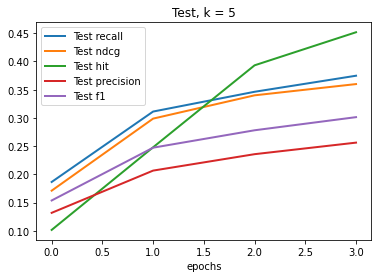

In [29]:
main()